In [262]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [110]:
query = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM default.ldn_listings
WHERE review_scores_rating is not null
ORDER BY id
LIMIT 1000
'''

In [111]:
df = ph.read_clickhouse(query=query, connection=connection_default)

In [114]:
df.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [120]:
mean_price_rating = df.groupby('room_type', as_index=False).mean()

In [121]:
mean_price_rating

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


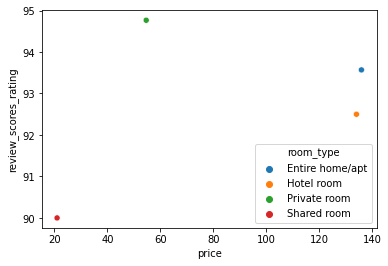

In [125]:
sns.scatterplot(data=mean_price_rating, x="price", y="review_scores_rating", hue="room_type")

In [126]:
query2 = '''
SELECT
    DISTINCT host_id,
    host_verifications
FROM default.ldn_listings
WHERE experiences_offered != 'none'
'''

In [184]:
df2 = ph.read_clickhouse(query=query2, connection=connection_default)

In [190]:
df2['host_verifications'] = df2.host_verifications.apply(lambda x: x.strip() \
                                                         .replace('[', '') \
                                                         .replace(']', '') \
                                                         .replace('\'', '') \
                                                         .split(', '))


In [203]:
df2.explode('host_verifications').groupby('host_verifications').count().sort_values('host_id')

,host_id
host_verifications,
sent_id,6
manual_online,16
kba,27
google,34
manual_offline,70
identity_manual,227
selfie,252
facebook,270
work_email,279


In [204]:
query3 = '''
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    count(id) as experiences_count
FROM default.ldn_listings
where experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
'''

In [205]:
df3 = ph.read_clickhouse(query=query3, connection=connection_default)

In [206]:
df3

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [210]:
??df.pivot

In [212]:
pivoted = df3.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

In [213]:
pivoted.head(5)

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0


In [227]:
??sns.heatmap

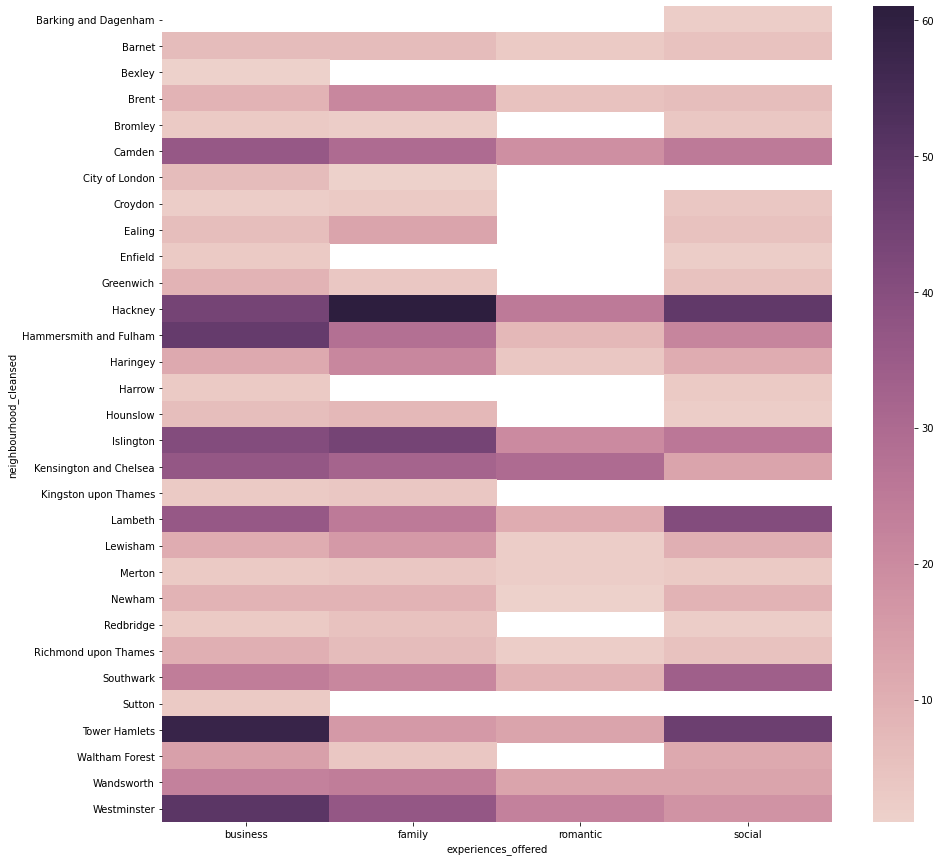

In [237]:
cmap=sns.cubehelix_palette(as_cmap=True)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(pivoted, cmap=cmap)


In [243]:
query4 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    
FROM default.ldn_listings
where experiences_offered != 'none'
'''

In [244]:
df4 = ph.read_clickhouse(query=query4, connection=connection_default)

In [249]:
df4.head()

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0


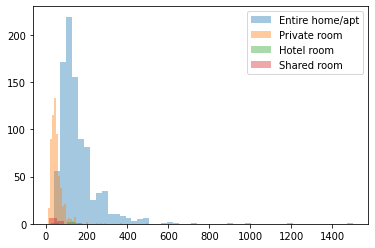

In [261]:
sns.distplot(x=df4.query("room_type == 'Entire home/apt'").price, label='Entire home/apt', kde=False)
sns.distplot(x=df4.query("room_type == 'Private room'").price, label='Private room', kde=False)
sns.distplot(x=df4.query("room_type == 'Hotel room'").price, label='Hotel room', kde=False)
sns.distplot(x=df4.query("room_type == 'Shared room'").price, label='Shared room', kde=False)
plt.legend()
plt.show()

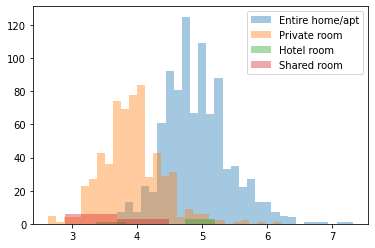

In [263]:
sns.distplot(x=np.log(df4.query("room_type == 'Entire home/apt'").price), label='Entire home/apt', kde=False)
sns.distplot(x=np.log(df4.query("room_type == 'Private room'").price), label='Private room', kde=False)
sns.distplot(x=np.log(df4.query("room_type == 'Hotel room'").price), label='Hotel room', kde=False)
sns.distplot(x=np.log(df4.query("room_type == 'Shared room'").price), label='Shared room', kde=False)
plt.legend()
plt.show()

In [264]:
query5 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr,
    first_review
FROM default.ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
'''

In [265]:
df5 = ph.read_clickhouse(query=query5, connection=connection_default)

In [271]:
df5['first_review'] = df5.first_review.apply(lambda x: x[:4])

In [278]:
grooped = df5.groupby(['room_type', 'first_review'], as_index=False).mean().sort_values('first_review')

In [280]:
grooped.head()

,room_type,first_review,price_corr
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143


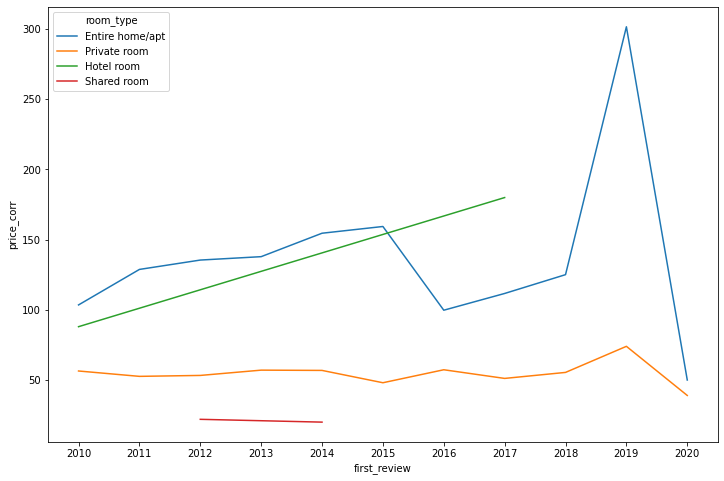

In [281]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price_corr',hue='room_type',data=grooped)